# Demo File
This demo tests the functionality of the EchoStateNetwork with different time series

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ESN import EchoStateNetwork
from ESN import MackeyGlassGenerator
from ESN import GinfActivator

ginf_activator = GinfActivator(V_min=-2, V_max=2, resolution=200, offset=True)


def mse(test, predictions):
    return np.mean((predictions - test) ** 2)

## Steady State Conductance Activator

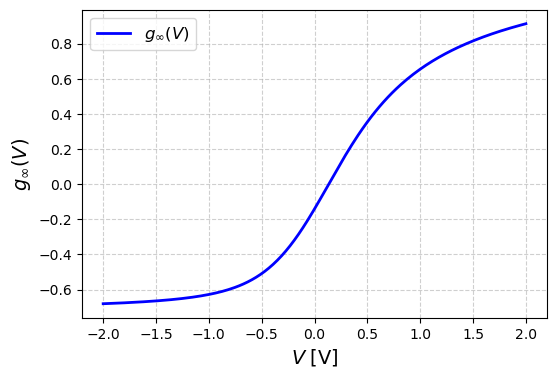

In [3]:
lookup_table = ginf_activator.get_lookup_table()

plt.figure(figsize=(6, 4))
plt.plot(
    lookup_table[0],
    lookup_table[1],
    label=r"$g_{\infty}(V)$",
    color="blue",
    linewidth=2,
)
plt.xlabel(r"$V \;[\text{V}]$", fontsize=14)
plt.ylabel(r"$g_{\infty}(V)$", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.savefig("output/ginf_activator_plot.pdf")
plt.savefig("output/ginf_activator_plot.png")

## ESN with Mackey-Glass time series

In [9]:
esn = EchoStateNetwork(
    input_dim=1,
    reservoir_size=10,
    output_dim=1,
    leaking_rate=1,
    step_size=0.01,
    time_scale=0.1,
    spectral_radius=0.9, #guarantee_ESP could change spectral radius if True
    sparsity=0.85,
    input_scaling=0.5,
    regularization=1e-6,
    weight_seed=42,
    activation=ginf_activator.activate,
    guarantee_ESP=False,
)

0.9348320843564982
0.8999999999999997
This initilization has the echo state property
34.64101615137755


In [11]:
# Generate Mackey-Glass time series
mg_series = MackeyGlassGenerator(tau=15, n=10000, n_samples=5000)

# Normalize data between -1 and 1
mg_series = 2 * (mg_series - mg_series.min()) / (mg_series.max() - mg_series.min()) - 1

# Create input/output pairs for time series prediction
inputs = mg_series[:-1].reshape(-1, 1)
targets = mg_series[1:].reshape(-1, 1)

# Split into train and test sets
train_len = 4000
test_len = 1000
train_inputs = inputs[:train_len]
train_targets = targets[:train_len]
test_inputs = inputs[train_len : train_len + test_len]
test_targets = targets[train_len : train_len + test_len]

In [21]:
esn = EchoStateNetwork(
    input_dim=1,
    reservoir_size=10,
    output_dim=1,
    leaking_rate=1,
    step_size=0.05,
    time_scale=0.25,
    spectral_radius=0.9,
    sparsity=0.85,
    input_scaling=0.5,
    regularization=1e-6,
    activation=ginf_activator.activate,
    guarantee_ESP=True,
)

washout = 100

# Train on first part of series
esn.fit(train_inputs, train_targets, washout=washout)

# Generate predictions on test set
predictions = esn.predict(test_inputs)

# Calculate prediction error after network settled from np.zeroes initialization
print(f"Test MSE: {mse(test_targets[washout:], predictions[washout:])}")

0.8546906665038714
0.7764644453184566
54.772255750516614


Test MSE: 0.0010126756264022025


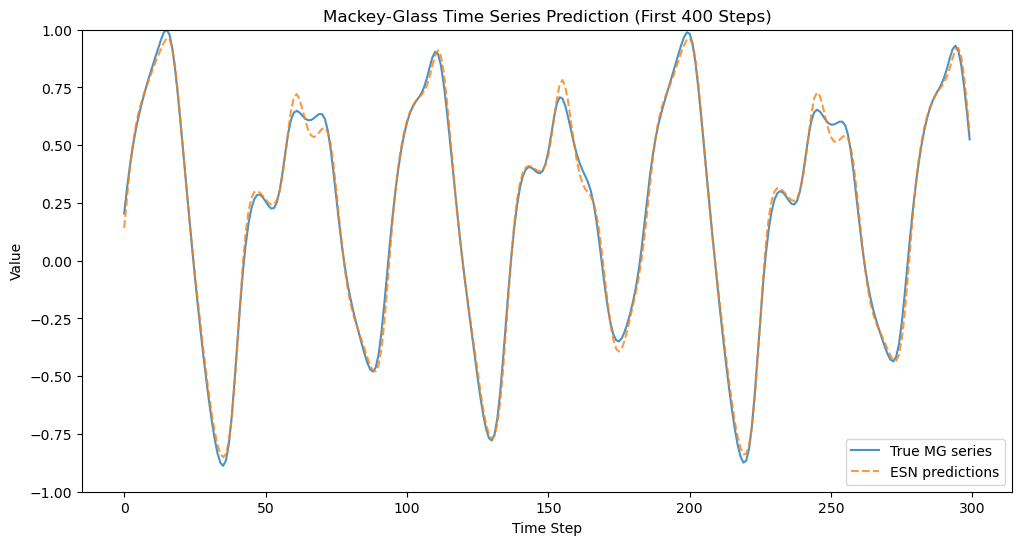

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(test_targets[washout:400], label="True MG series", alpha=0.8)
plt.plot(predictions[washout:400], label="ESN predictions", linestyle="--", alpha=0.8)
plt.title("Mackey-Glass Time Series Prediction (First 400 Steps)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.ylim(-1, 1)
plt.legend()
plt.savefig("output/mg_prediction_plot.pdf")
plt.savefig("output/mg_prediction_plot.png")

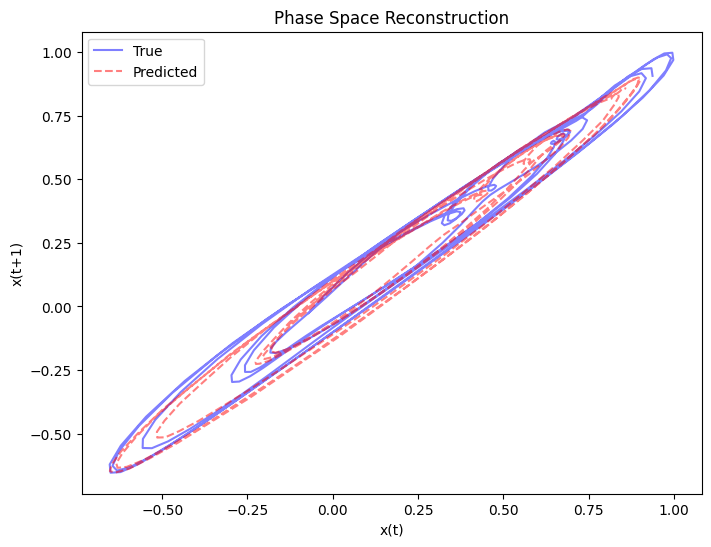

In [ ]:
# Plot phase space reconstruction
plt.figure(figsize=(8, 6))
plt.plot(
    test_targets[:-1][washout:400],
    test_targets[1:][washout:400],
    "b-",
    alpha=0.5,
    label="True",
)
plt.plot(
    predictions[:-1][washout:400],
    predictions[1:][washout:400],
    "r--",
    alpha=0.5,
    label="Predicted",
)
plt.title("Phase Space Reconstruction")
plt.xlabel("x(t)")
plt.ylabel("x(t+1)")
plt.legend()
plt.savefig("output/mg_phase_space_plot.pdf")
plt.savefig("output/mg_phase_space_plot.png")

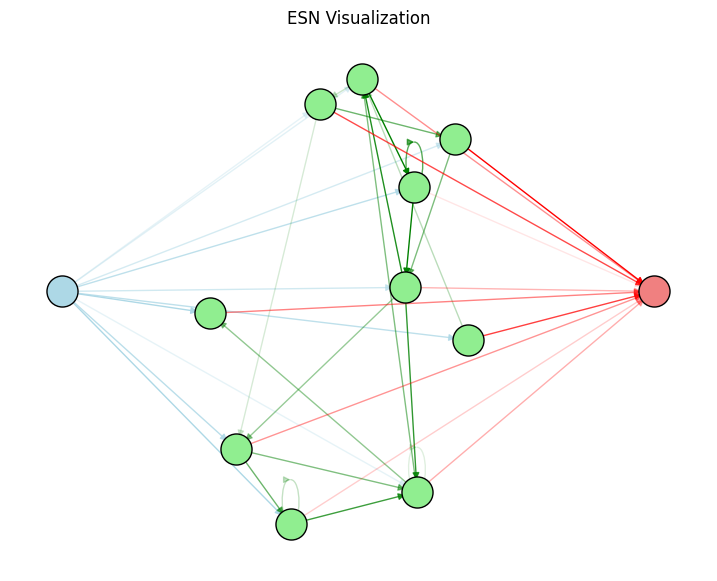

In [7]:
esn.visualize_reservoir()

## ESN with Harmonic Wave time series

In [8]:
# Generate synthetic data (simple sine wave prediction)
t = np.linspace(0, 6 * np.pi, 1000)
data = np.sin(t) * np.cos(t) * t

# Create input/output pairs for time series prediction
inputs = data[:-1].reshape(-1, 1)
targets = data[1:].reshape(-1, 1)

In [ ]:
# Initialize and train ESN
esn = EchoStateNetwork(
    input_dim=1,
    reservoir_size=10,
    output_dim=1,
    leaking_rate=1,
    step_size=0.3,
    time_scale=1,
    spectral_radius=0.95,
    sparsity=0.7,
    input_scaling=1.0,
    regularization=1e-4,
    activation=np.tanh,
)

# Train on synthetic data
esn.fit(inputs, targets, washout=100)

# Generate predictions
predictions = esn.predict(inputs)

# Calculate prediction error after network settled from np.zeroes initialization
print(f"{mse(targets[washout:], predictions[washout:]) = }")

mse(targets[washout:], predictions[washout:]) = np.float64(0.0028517637636318264)


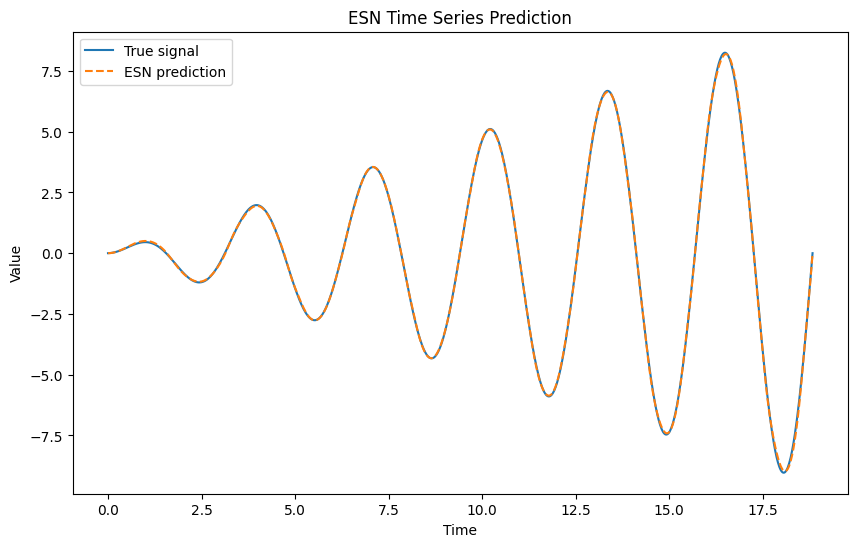

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(t[:-1], targets, label="True signal")
plt.plot(t[:-1], predictions, label="ESN prediction", linestyle="--")
plt.title("ESN Time Series Prediction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.savefig("output/sine_prediction_plot.pdf")
plt.savefig("output/sine_prediction_plot.png")

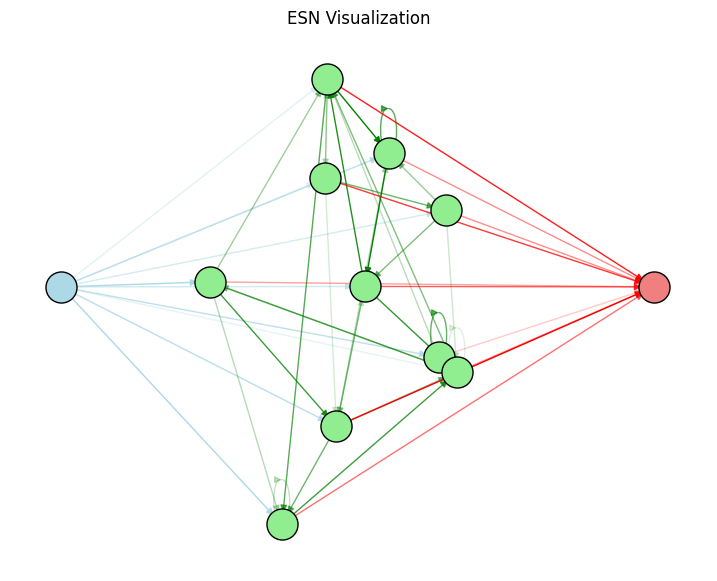

In [11]:
esn.visualize_reservoir()

## ESN with Ventilator Pressure Prediction data

In [165]:
import polars as pl

In [166]:
data = pl.read_csv(r"data\ventilator-pressure-prediction\train.csv")[:100000]

data = data.to_dummies(columns=["R", "C"])

# data = data.with_columns(
#     pl.col("u_in").cum_sum().over("breath_id").alias("u_in_cumsum")
# )

# data = data.with_columns(
#     pl.col("time_step")
#     .diff()
#     .over("breath_id")
#     .fill_null(0)
#     .map_elements(lambda x: max(x, 0), pl.Float64)
#     .alias("time_delta")
# )

# data = data.with_columns(
#     (pl.col("time_delta") * pl.col("u_in")).alias("u_in_area")
# ).with_columns(pl.col("u_in_area").cum_sum().over("breath_id").alias("area_true"))

# data = data.with_columns(
#     pl.col("u_in").diff().over("breath_id").fill_null(0).alias("u_in_diff")
# )

split = int(len(data) * 0.8)

train_x = data.drop('id','breath_id',"pressure")[:split].to_numpy()
train_y = data[["pressure"]][:split].to_numpy()
test_x = data.drop('id','breath_id',"pressure")[split:].to_numpy()
test_y = data[["pressure"]][split:].to_numpy()

data.drop('id','breath_id',"pressure")[:split].head()

R_20,R_5,R_50,C_10,C_20,C_50,time_step,u_in,u_out
u8,u8,u8,u8,u8,u8,f64,f64,i64
1,0,0,0,0,1,0.0,0.083334,0
1,0,0,0,0,1,0.033652,18.383041,0
1,0,0,0,0,1,0.067514,22.509278,0
1,0,0,0,0,1,0.101542,22.808822,0
1,0,0,0,0,1,0.135756,25.35585,0


In [167]:
esn = EchoStateNetwork(
    input_dim=train_x.shape[1],
    reservoir_size=85,
    output_dim=train_y.shape[1],
    leaking_rate=0.66,
    step_size=0.18,
    time_scale=3.1,
    spectral_radius=0.16,
    sparsity=0.75,
    input_scaling=0.1,
    regularization=0.00047855525,
    activation=ginf_activator.activate,
    guarantee_ESP=True,
    progress_bar=True,
)

washout = 0

esn.fit(train_x, train_y, washout=washout)


In [168]:
predictions = esn.predict(test_x)
print(f"Test MSE: {mse(test_y[washout:], predictions[washout:])}")

Test MSE: 11.694570222337616


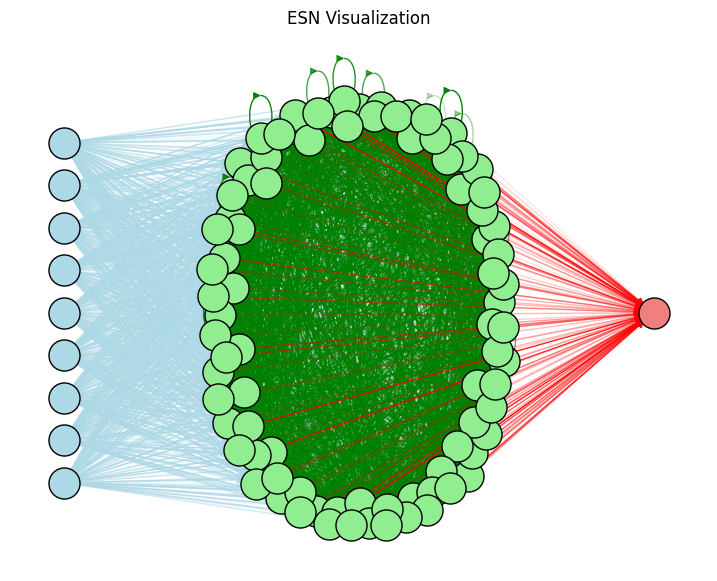

In [171]:
esn.visualize_reservoir(draw_labels=False)

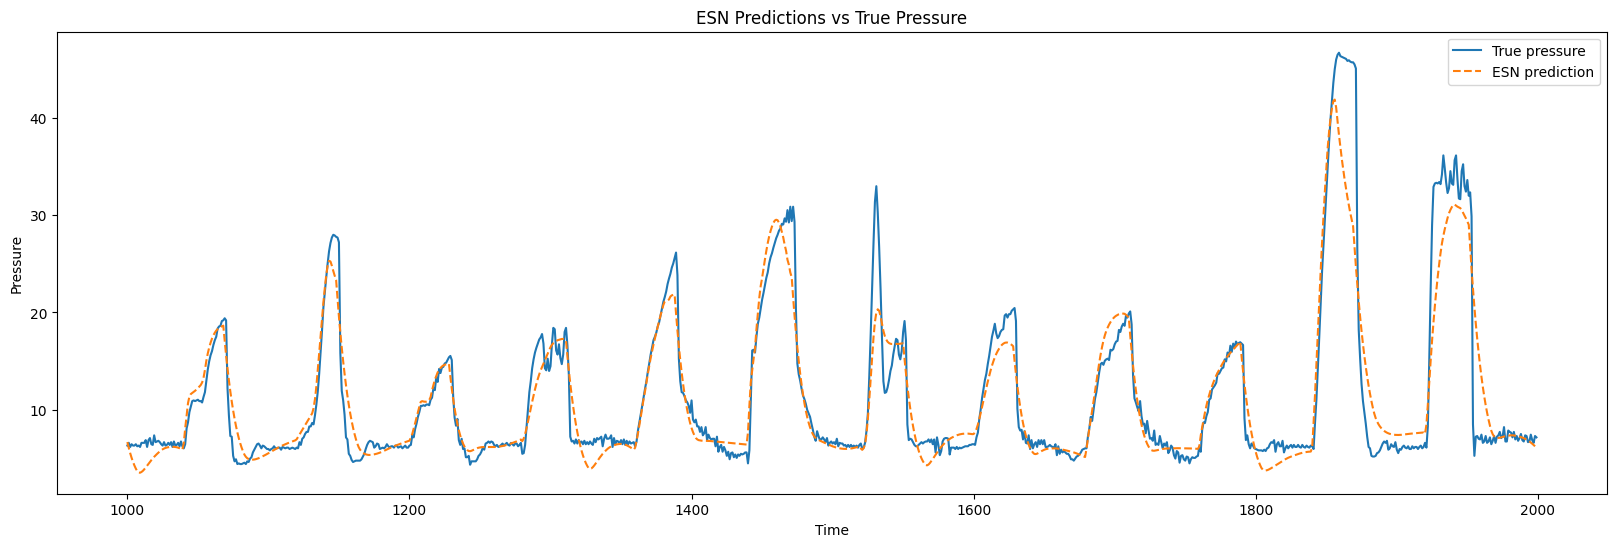

In [170]:
plt.figure(figsize=(20, 6))
plt.plot(range(len(test_y))[1000:2000], test_y[1000:2000], label="True pressure")
plt.plot(
    range(len(test_y))[1000:2000],
    predictions[1000:2000],
    label="ESN prediction",
    linestyle="--",
)
plt.title("ESN Predictions vs True Pressure")
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.legend()
plt.show()